In [89]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [90]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [91]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

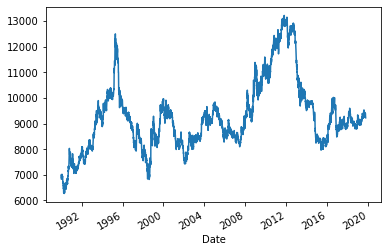

In [92]:
# Plot just the "Settle" column from the dataframe

yen_futures.Settle.plot()

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [93]:
import statsmodels.api as sm
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
settle_noise, settle_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [94]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
df_settle = pd.DataFrame(yen_futures['Settle'])
df_settle['Noise'] = settle_noise
df_settle['Trend'] = settle_trend

<AxesSubplot:title={'center':'Settle vs. Trend'}, xlabel='Date'>

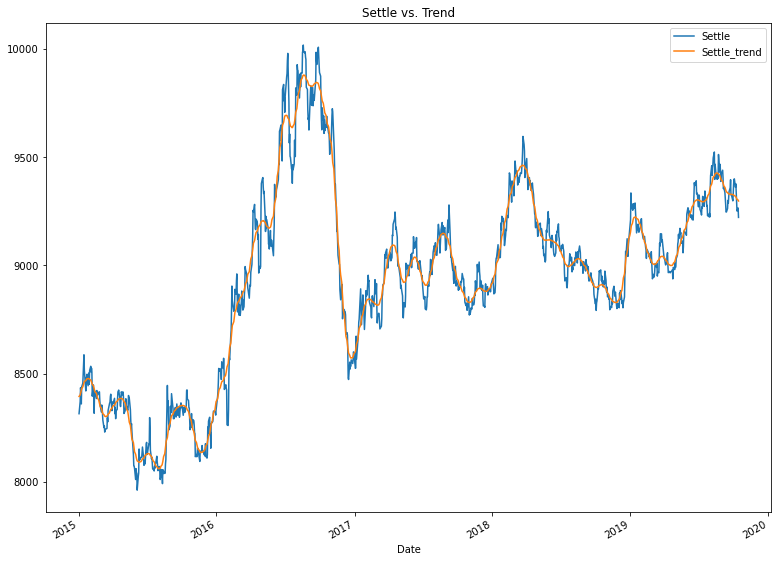

In [95]:
# Plot the Settle Price vs. the Trend for 2015 to the present
set_price_2015_present = yen_futures.loc['2015-01-01':]
trend_2015_present = settle_trend.loc['2015-01-01':]
settle_vs_trend = pd.concat([set_price_2015_present, trend_2015_present], axis="columns", join="inner")
settle_vs_trend_split = settle_vs_trend[['Settle', 'Settle_trend']]
settle_vs_trend_split.plot(figsize = (13,10), title = 'Settle vs. Trend')


<AxesSubplot:xlabel='Date'>

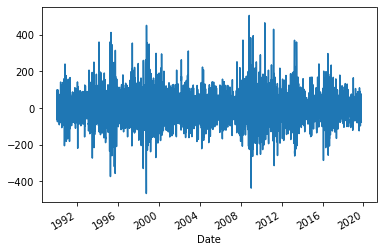

In [96]:
# Plot the Settle Noise
settle_noise.plot()

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [97]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [98]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(yen_futures.Settle.values, order=(2,1))

C:\Users\likem\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [99]:
# Fit the model and assign it to a variable called results
results = model.fit()

In [100]:
# Output model summary results:
results.forecast(steps=2)

(array([9222.67578334, 9223.46810608]),
 array([64.2769234, 90.1755665]),
 array([[9096.69532844, 9348.65623825],
        [9046.72724346, 9400.2089687 ]]))

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

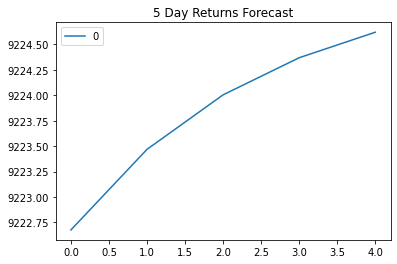

In [101]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [102]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model_1 = ARIMA(yen_futures.Settle.values, order=(5, 1, 1))


# Fit the model
results_2 = model_1.fit()

C:\Users\likem\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\likem\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

In [103]:
# Output model summary results:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Sat, 22 May 2021   AIC                          83905.238
Time:                        13:17:28   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3162      0.700      0.452      0.651      -1.056       1.688
ar.L1.D.y      0.2824      0.699      0.404      0.686      -1.088       1.652
ar.L2.D.y      0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.y     -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.y     -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.y     -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.y     -0.2974      0.699     -0.426      0.670      -1.667       1.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8920           -1.3784j            2.3409           -0.1002
AR.2            1.8920           +1.3784j            2.3409            0.1002
AR.3           -2.2710           -3.0200j            3.7787           -0.3526
AR.4           -2.2710           +3.0200j            3.7787            0.3526
AR.5          -11.1027           -0.0000j           11.1027           -0.5000
MA.1            3.3625           +0.0000j            3.3625            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Price Forecast'}>

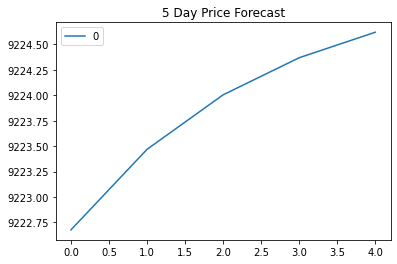

In [104]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Price Forecast")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [105]:
from arch import arch_model

In [106]:
# Estimate a GARCH model:
model_3 = arch_model(yen_futures['Settle'], mean="Zero", vol="GARCH", p=2, q=1)

In [107]:
# Fit the model
res = model_3.fit(disp="off")

C:\Users\likem\anaconda3\lib\site-packages\arch\univariate\base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.872e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [86]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -79212.8
Distribution:                  Normal   AIC:                           158434.
Method:            Maximum Likelihood   BIC:                           158461.
                                        No. Observations:                 7515
Date:                Sat, May 22 2021   Df Residuals:                     7515
Time:                        13:12:38   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.7475e+06  1.135e+05     15.399  1.668e-53  [1.525e+06,1.970e+06]
alpha[1]       0.9762  1.706e-02     57.222      0.000      [  0.943,  1.010]
alpha[2]   2.3745e-03  5.384e-02  4.410e-02      0.965      [ -0.103,  0.108]
beta[1]        0.0000  5.093e-02      0.000      1.000 [-9.982e-02,9.982e-02]
=============================================================================

Covariance estimator: robust
"""

In [108]:
# Find the last day of the dataset
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [112]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts_hz = res.forecast(start=last_day, horizon=forecast_horizon)
forecasts_hz

In [113]:
# Annualize the forecast
ann_for = np.sqrt(forecasts_hz.variance.dropna() * 252)
ann_for.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,146322.255059,146257.600787,146194.306175,146132.339642,146071.673866


In [115]:
# Transpose the forecast so that it is easier to plot
trans_for = ann_for.dropna().T
trans_for.head()

Date,2019-10-15
h.1,146322.255059
h.2,146257.600787
h.3,146194.306175
h.4,146132.339642
h.5,146071.673866


<AxesSubplot:title={'center':'5 Day Forecast of Volatility'}>

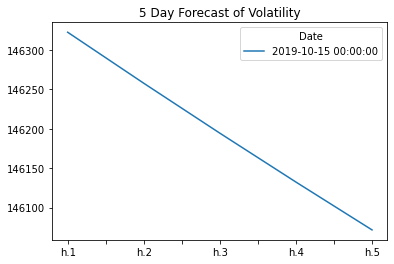

In [116]:
# Plot the final forecast
trans_for.plot(title='5 Day Forecast of Volatility', legend=True)

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

based on the time series analysis no i would not but the yen now.
the risk of the Yen is expected to increase.
yes. the model evaluation gave good insight on the volitility of the Yen.